In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cbook as cbk
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import (confusion_matrix, accuracy_score)
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from statsmodels.stats.outliers_influence import variance_inflation_factor
from functions import *
from scipy.stats import t, shapiro
import scipy.stats as stats
import statsmodels
from math import dist

In [2]:
billets = pd.read_csv("billets.csv", sep = ";")

# I Analyse univariée

In [3]:
billets.describe(include = 'all')


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
unique,2,NaN,NaN,NaN,NaN,NaN,NaN
top,True,NaN,NaN,NaN,NaN,NaN,NaN
freq,1000,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,NaN,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,NaN,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,NaN,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,NaN,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,NaN,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000


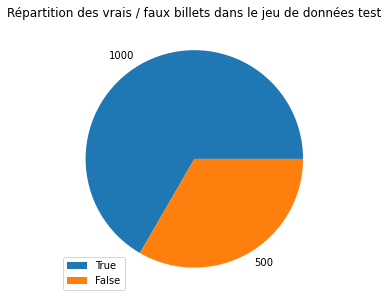

In [4]:
fig = plt.figure(figsize= (10,5))
plt.pie(billets["is_genuine"].value_counts(),  labels = billets["is_genuine"].value_counts())
plt.legend(billets["is_genuine"].unique())
plt.title("Répartition des vrais / faux billets dans le jeu de données test")
plt.show()

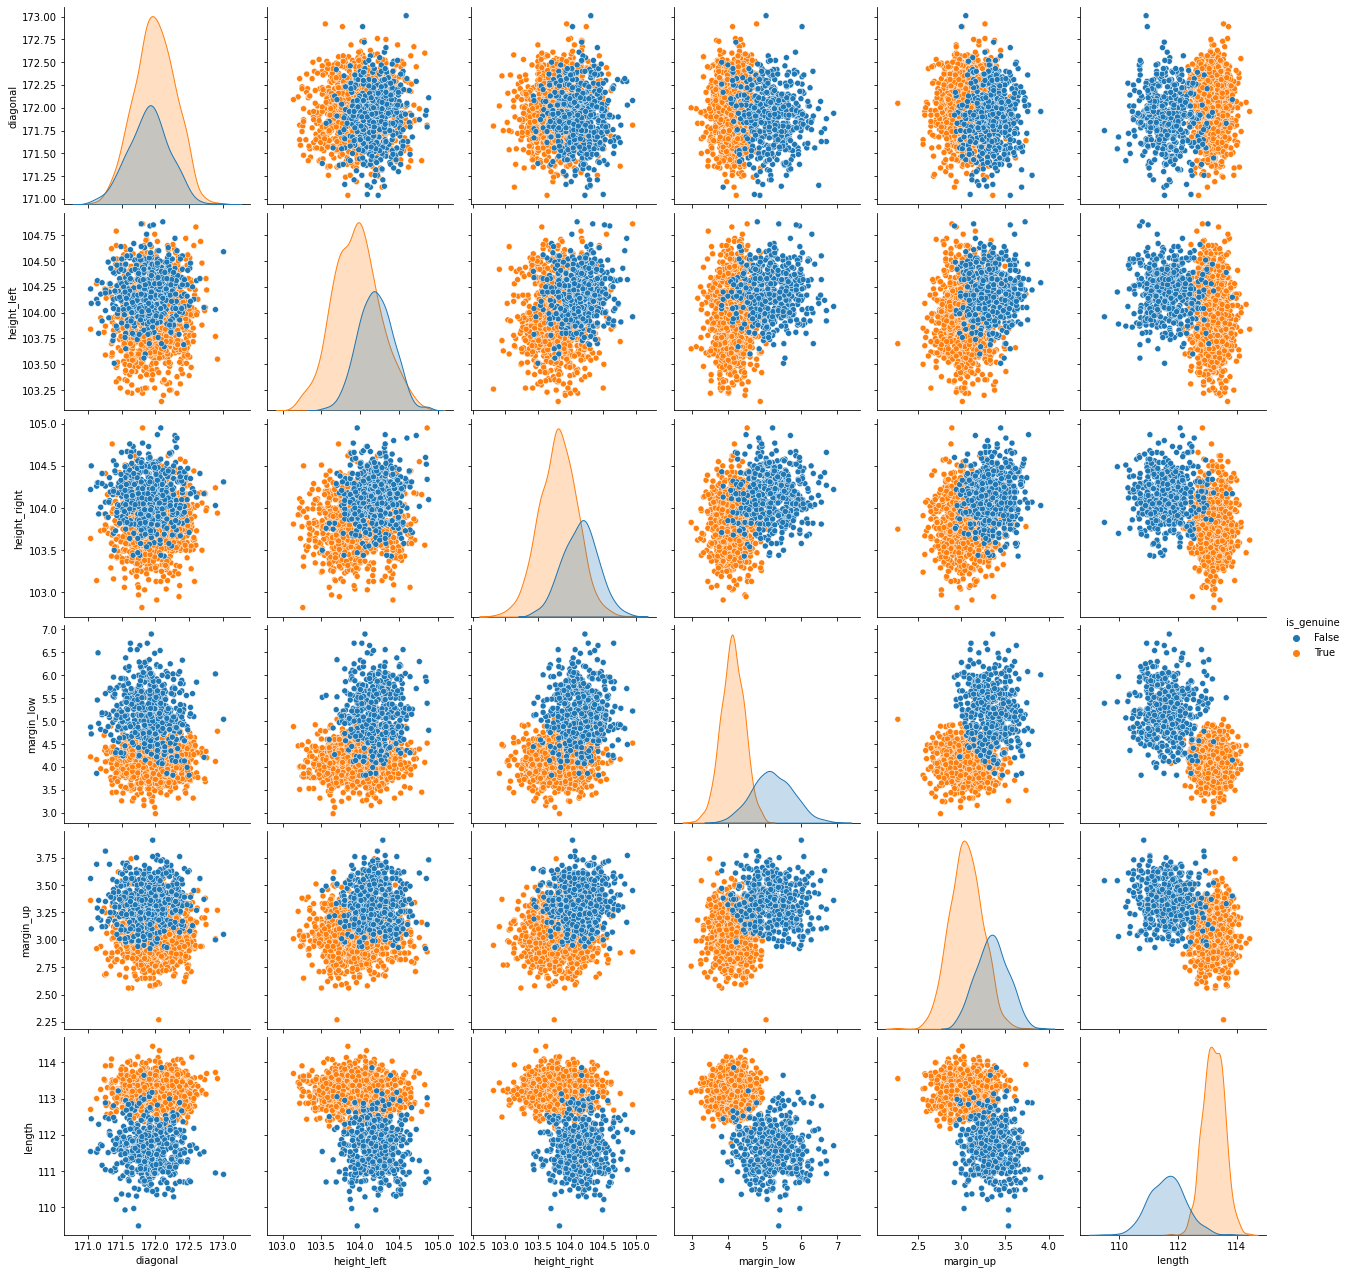

In [5]:
sns.pairplot(billets, hue='is_genuine', height=3);

In [6]:
billets

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


# II Nettoyage des données
##  Recherche des doublons et des valeurs nulles

In [7]:
billets.duplicated().value_counts()

False    1500
dtype: int64

In [8]:
billets.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


On constate qu'il existe des données manquantes (37valeurs) sur la variable "margin_low".

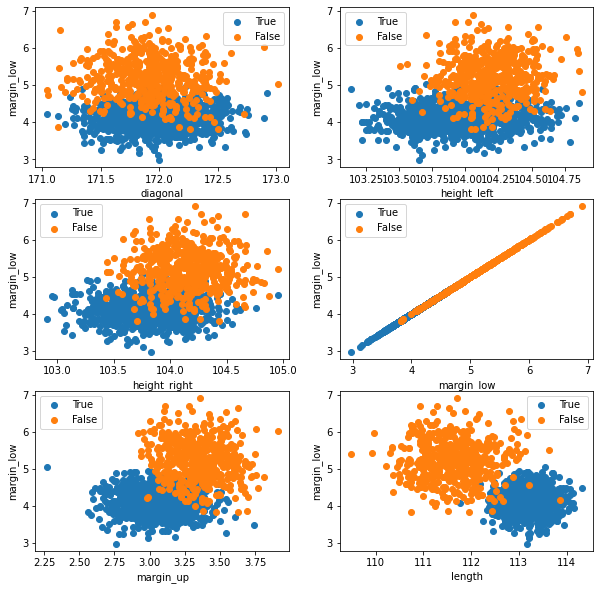

In [9]:
fig = plt.figure(figsize = (10,10))
for i,col in enumerate (np.array(billets.columns[1:])) :
    ax = fig.add_subplot(3,2,i+1)
    ax.scatter(billets[billets["is_genuine"]==True][col], billets[billets["is_genuine"]==True]["margin_low"])
    ax.scatter(billets[billets["is_genuine"]==False][col], billets[billets["is_genuine"]==False]["margin_low"])
    ax.set_xlabel(col)
    ax.set_ylabel("margin_low")
    ax.legend((True, False))
    
plt.show()

In [10]:
billets["is_genuine"].replace([False, True],[0,1], inplace = True)


## Réalisez une régression linéaire simple

Essayons de lancer une régression linéaire simple sur ce nuage de points :

In [11]:
reg_simp = smf.ols('margin_low ~ length', data=billets).fit() 

In [12]:
print(reg_simp.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     1169.
Date:                Tue, 21 Jun 2022   Prob (F-statistic):          8.98e-189
Time:                        12:18:17   Log-Likelihood:                -1045.8
No. Observations:                1463   AIC:                             2096.
Df Residuals:                    1461   BIC:                             2106.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     61.5960      1.670     36.881      0.0

## Visualisez la droite de régression

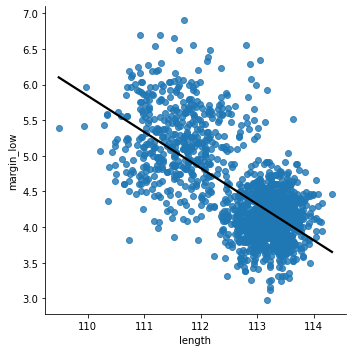

In [13]:
ax = sns.lmplot(x="length", y="margin_low", data=billets, ci=None, line_kws={'color':'black'})
ax.set(xlabel='length', ylabel='margin_low')
ax.set_titles("Droite de régression")
plt.show()

## Réalisez une régression linéaire multiple


In [16]:
billets.columns

Index(['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_low',
       'margin_up', 'length'],
      dtype='object')

In [17]:
reg_multi = smf.ols('margin_low~diagonal+height_left+height_right+is_genuine+margin_up+length', data=billets).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     390.7
Date:                Tue, 21 Jun 2022   Prob (F-statistic):          4.75e-299
Time:                        12:18:18   Log-Likelihood:                -774.14
No. Observations:                1463   AIC:                             1562.
Df Residuals:                    1456   BIC:                             1599.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.8668      8.316      0.345   

on retire la variable 'length', qui présente une p value supérieure à 0,05

In [18]:
reg_multi = smf.ols('margin_low~diagonal+height_left+height_right+is_genuine+margin_up', data=billets).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     469.2
Date:                Tue, 21 Jun 2022   Prob (F-statistic):          2.12e-300
Time:                        12:18:18   Log-Likelihood:                -774.15
No. Observations:                1463   AIC:                             1560.
Df Residuals:                    1457   BIC:                             1592.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.4247      7.873      0.308   

on retire la variable 'diagonal', qui présente une p value supérieure à 0,05

In [19]:
reg_multi = smf.ols('margin_low~height_left+height_right+is_genuine+margin_up', data=billets).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     586.8
Date:                Tue, 21 Jun 2022   Prob (F-statistic):          8.76e-302
Time:                        12:18:18   Log-Likelihood:                -774.21
No. Observations:                1463   AIC:                             1558.
Df Residuals:                    1458   BIC:                             1585.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.3902      5.476      0.071   

on retire la variable 'height_right', qui présente une p value supérieure à 0,05

In [20]:
reg_multi = smf.ols('margin_low~height_left+is_genuine+margin_up', data=billets).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     782.5
Date:                Tue, 21 Jun 2022   Prob (F-statistic):          3.63e-303
Time:                        12:18:18   Log-Likelihood:                -774.45
No. Observations:                1463   AIC:                             1557.
Df Residuals:                    1459   BIC:                             1578.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.9104      4.035      0.721      

on retire la variable 'height_left', qui présente une p value supérieure à 0,05

In [21]:
reg_multi = smf.ols('margin_low~is_genuine+margin_up', data=billets).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1174.
Date:                Tue, 21 Jun 2022   Prob (F-statistic):          1.24e-304
Time:                        12:18:18   Log-Likelihood:                -774.73
No. Observations:                1463   AIC:                             1555.
Df Residuals:                    1460   BIC:                             1571.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.9263      0.198     30.003      0.0

On remarque que tous les paramètres sont significatifs -leur p-valeur est inférieure à 5 %, le niveau de test que nous souhaitons-. Quant au $R^{2}$, il vaut environ 0.62, tout comme le $R^{2}$ ajusté.

*On peut donc utiliser ce modèle à des fins de prévision !*

## Vérifier la colinéarité des variables

On peut vérifier la colinéarité approchée des variables :

In [22]:
variables = reg_multi.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.5938854494007753, 1.5938854494007748]

Ici, tous les coefficients sont inférieurs à 10, il n'y a donc pas de problème de colinéarité.

## Testez l’homoscédasticité

On peut également tester l’homoscédasticité (c'est-à-dire la constance de la variance) des résidus :

In [23]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(reg_multi.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 3.203355911584878e-36


La p-valeur ici est inférieure à $5$%, on rejette l'hypothèse $H0$ selon laquelle les variances sont constantes (l'hypothèse d’homoscédasticité).


## Testez la normalité des résidus

Si l'on veut tester la normalité des résidus, on peut faire un test de Shapiro-Wilk.

In [24]:
shapiro(reg_multi.resid)

ShapiroResult(statistic=0.9936248064041138, pvalue=6.20942773821298e-06)

Ici, l'hypothèse de normalité est remise en cause (p-value < $5%$).

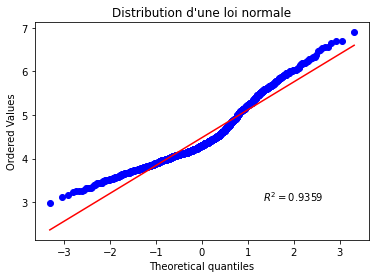

In [80]:
# Représentation graphique de la distribution d'une loi normale
plt.figure()
stats.probplot(billets.margin_low, dist="norm", plot=plt, rvalue=True)
plt.title("Distribution d'une loi normale")
plt.show()

La vérification visuelle de la distribution sur un échantillon volumineux consiste à utiliser un graphique de probabilité pour évaluer la corrélation des valeurs observées avec la distribution normale. Le graphique génère un tracé de probabilité des données par rapport à l'échelle des quantiles théoriques d'une distribution normale. La line indique le meilleur ajustement pour les données par rapport à la loi normale et le coefficient de détermination linéaire mesure l'adéquation de notre variable à la loi normale, soit 94 % des points sont déterminés par la droite de régression

## Prédiction des valeurs manquantes

In [26]:
billets.columns

Index(['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_low',
       'margin_up', 'length'],
      dtype='object')

In [27]:
a_predire = billets[billets["margin_low"].isnull()][["is_genuine","diagonal","height_left","height_right","margin_up","length"]]

margin_low_pred_reg_multi = reg_multi.predict(a_predire)
margin_low_pred_reg_multi

72      4.074248
99      4.097561
151     4.122994
197     3.995830
241     4.122994
251     4.137830
284     4.078487
334     4.127233
410     4.101800
413     4.093322
445     4.125114
481     4.188696
505     4.131472
611     4.063651
654     4.190815
675     4.220487
710     4.112397
739     4.108158
742     4.076367
780     4.099681
798     4.125114
844     4.129352
845     4.148427
871     4.112397
895     4.131472
919     4.216248
945     4.122994
946     4.070009
981     4.129352
1076    5.245925
1121    5.254403
1176    5.286194
1303    5.305269
1315    5.205657
1347    5.161149
1435    5.171746
1438    5.239567
dtype: float64

On remplace les valeurs nulles par les valeurs prédites grâce à la régression linéaire multiple.

In [28]:
billets.loc[billets["margin_low"].isnull(), 'margin_low'] = margin_low_pred_reg_multi

In [29]:
billets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   int64  
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 82.2 KB


# III Régression logistique

## Définition, entraînement et test du modèle

In [30]:
# étiquettes
y = billets['is_genuine']

In [31]:
# varaibles explicatives quantitatives
X = billets.drop('is_genuine', axis = 1)

In [32]:
#création du jeu d'entraînement et du jeu de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=10)

In [33]:
# les jeux d'entraînement et de test sont stratifiés : la proportion de points positifs / négatifs est respectée
y_train.value_counts()

1    800
0    400
Name: is_genuine, dtype: int64

In [34]:
y_test.value_counts()

1    200
0    100
Name: is_genuine, dtype: int64

In [35]:
#concaténation du jeu de données d'entraînement
data_train =  pd.concat([y_train, X_train], axis=1)

In [36]:
reg_log = smf.glm('is_genuine~diagonal+height_left+height_right+margin_low+margin_up+length',
                   data=data_train, family=sm.families.Binomial()).fit()
print(reg_log.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             is_genuine   No. Observations:                 1200
Model:                            GLM   Df Residuals:                     1193
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -23.923
Date:                Tue, 21 Jun 2022   Deviance:                       47.845
Time:                        12:18:19   Pearson chi2:                     136.
No. Iterations:                    11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     -281.8148    323.453     -0.871   

On retire la variable 'diagonal', qui présente la p_value la plus élevée

In [37]:
reg_log = smf.glm('is_genuine~height_left+height_right+margin_low+margin_up+length',
                   data=data_train, family=sm.families.Binomial()).fit()
print(reg_log.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             is_genuine   No. Observations:                 1200
Model:                            GLM   Df Residuals:                     1194
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -23.980
Date:                Tue, 21 Jun 2022   Deviance:                       47.960
Time:                        12:18:19   Pearson chi2:                     133.
No. Iterations:                    11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     -202.2066    220.824     -0.916   

on retire la variable 'hiegh_left'

In [38]:
reg_log = smf.glm('is_genuine~height_right+margin_low+margin_up+length',
                   data=data_train, family=sm.families.Binomial()).fit()
print(reg_log.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             is_genuine   No. Observations:                 1200
Model:                            GLM   Df Residuals:                     1195
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -25.402
Date:                Tue, 21 Jun 2022   Deviance:                       50.803
Time:                        12:18:19   Pearson chi2:                     140.
No. Iterations:                    11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     -418.7726    174.104     -2.405   

on retire la variable 'height_right', qui présente une p value supérieure à 0,05

In [39]:
reg_log = smf.glm('is_genuine~margin_low+margin_up+length',
                   data=data_train, family=sm.families.Binomial()).fit()
print(reg_log.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             is_genuine   No. Observations:                 1200
Model:                            GLM   Df Residuals:                     1196
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -28.277
Date:                Tue, 21 Jun 2022   Deviance:                       56.554
Time:                        12:18:19   Pearson chi2:                     127.
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -723.9708    120.363     -6.015      0.0

In [40]:
#calcul de la probabilité qu'un point soit positif sur le jeu de test
y_pred = reg_log.predict(X_test)

In [41]:
y_pred

198     9.984755e-01
826     9.999998e-01
902     9.961985e-01
541     9.998298e-01
1271    2.733075e-05
            ...     
824     9.977144e-01
1417    1.094853e-04
1073    3.553522e-01
1284    2.376740e-07
1234    1.745765e-05
Length: 300, dtype: float64

In [42]:
prediction = list(map(round, y_pred))

In [43]:
# confusion matrix
cm_logistic_reg = confusion_matrix(y_test, prediction)
print ("Confusion Matrix (tn, fp, fn, tp) : \n", cm_logistic_reg)

Confusion Matrix (tn, fp, fn, tp) : 
 [[ 98   2]
 [  0 200]]


In [44]:
# accuracy score of the model = proportion de points correctement prédits
print('Test accuracy = ', accuracy_score(y_test, prediction))

Test accuracy =  0.9933333333333333


In [85]:
#sensibilité = taux de vrais positifs, c’est à dire la proportion de positifs que l’on a correctement identifiés (TP/TP+FN) 
#C’est la capacité de notre modèle à détecter tous les faux billets
print(f'Sensibilité : {cm_logistic_reg[1][1]/(cm_logistic_reg[1][1]+cm_logistic_reg[1][0])}')

Sensibilité : 1.0


In [46]:
#spécificité = taux de vrais négatifs, c'est à dire la capacité à détecter tous les vrais billets (TN/TN+FP)
cm_logistic_reg
print(f'Spécificité : {cm_logistic_reg[0][0]/(cm_logistic_reg[0][0]+cm_logistic_reg[0][1])}')

Spécificité : 0.98


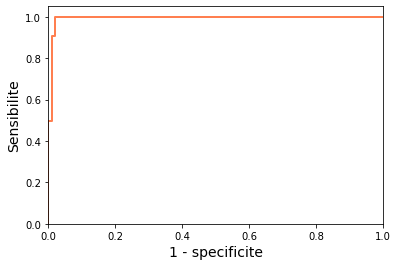

In [47]:
[fpr, tpr, thr] = metrics.roc_curve(y_test.replace(to_replace=[False, True], value = [1, 0]), y_pred)
plt.plot(fpr, tpr, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite', fontsize=14)
plt.ylabel('Sensibilite', fontsize=14)
plt.show()

In [48]:
print(metrics.auc(fpr, tpr))

0.994


Comment choisir un seuil de décision à partir de cette courbe ? On se fixe soit la spécificité, soit la sensibilité que l'on désire, et on cherche le seuil correspondant.

In [49]:
#indice du premier seuil pour lequel la sensibilité est supérieure à 0.95
idx = np.min(np.where(tpr > 0.95)) 

print("Sensibilité : {:.2f}".format(tpr[idx]))
print("Spécificité : {:.2f}".format(1-fpr[idx]))
print("Seuil : {:.2f}".format(thr[idx]))

Sensibilité : 1.00
Spécificité : 0.98
Seuil : 0.63


Utiliser un seuil de 0.63 nous garantit une sensibilité (vrais positifs) de 1 et une spécificité (vrais négatifs) de 0.98, soit un taux de faux négatifs de… 0%.

## Algorithme regression logistique

In [68]:
def pred_reg_log (csv) :
    data = pd.read_csv(csv)
    data = data.dropna()
    data = data.loc[:,['id','margin_low','margin_up','length']]
    predict = reg_log.predict(data)
    is_genuine = list(map(round,predict))
    data['is_genuine'] = is_genuine
    data['is_genuine'] = data['is_genuine'].replace(to_replace=[1, 0], value =[True, False])
    return data

In [51]:
pred_reg_log('billets_production.csv')

,id,margin_low,margin_up,length,is_genuine
0,A_1,5.21,3.30,111.42,False
1,A_2,6.00,3.31,112.09,False
2,A_3,4.99,3.39,111.57,False
3,A_4,4.44,3.03,113.20,True
4,A_5,3.77,3.16,113.33,True


# IV KMEANS 

In [52]:
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(X_train)

KMeans(n_clusters=2, random_state=0)

In [53]:
# récupération des coordonnées des centroïdes pour utilisation dans init
kmeans_centroides = kmeans.cluster_centers_

In [54]:
#création d'un np array avec les coordonnées des centroïdes
kmeans_centroides = np.array(kmeans_centroides)

In [55]:
# clustering par K-means avec initialisation des centroïdes aux coordonnées précedemment calculées
kmeans = KMeans(n_clusters=2, init = kmeans_centroides)
kmeans.fit(X_train)

# récupération des clusters attribués à chaque individu et des coordonnées des centroïdes
clusters_km = kmeans.predict(X_train)
clusters_km

/Users/fabienmirosa/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


array([0, 0, 1, ..., 1, 0, 0], dtype=int32)

In [56]:
y_train

612     1
757     1
1149    0
43      1
1105    0
       ..
550     1
1128    0
1206    0
661     1
684     1
Name: is_genuine, Length: 1200, dtype: int64

Il semblerait que le numéro de cluster attribué à True, 1, est 0, le numéro de cluster attribué à False, 0, est 1. 
vérification avec un crosstab

In [57]:
data_train_clusters = pd.DataFrame(y_train)
data_train_clusters["clusters_km"] = clusters_km

In [58]:
data_train_clusters

,is_genuine,clusters_km
612,1,0
757,1,0
1149,0,1
43,1,0
1105,0,1
...,...,...
550,1,0
1128,0,1
1206,0,1
661,1,0


In [59]:
pd.crosstab(data_train_clusters["is_genuine"], data_train_clusters["clusters_km"], margins=True)

clusters_km,0,1,All
is_genuine,,,
0,16,384,400
1,798,2,800
All,814,386,1200


In [60]:
#on inverse l'ordre des centroïdes pour faire correspondre a notre table initiale
kmeans_centroides = kmeans_centroides[[1,0]]

On peut utiliser la fonction 'dist' de la librairie math pour obtenir la distance euclidienne entre deux points

In [61]:
def predict_kmeans(df):
    centroids, df = np.array(kmeans_centroides), np.array(df)
    distances = []
    for i in df:
        for center in centroids:
            distances.append(dist(i, center))
    distances = np.reshape(distances, [len(df),2]) #2 clusters
    closest_centroid = [np.argmin(dist) for dist in distances]
    return(closest_centroid)

In [62]:
#classification des points du jeu de test par l'algotithme Kmeans
predict_kmeans = predict_kmeans(X_test)

In [63]:
cm_kmeans = confusion_matrix(y_test, predict_kmeans)
print ("Confusion Matrix, K-means (tn, fp, fn, tp) : \n", cm_kmeans)

Confusion Matrix, K-means (tn, fp, fn, tp) : 
 [[ 97   3]
 [  0 200]]


In [64]:
print ("Confusion Matrix, (tn, fp, fn, tp) : \n", cm_logistic_reg)

Confusion Matrix, (tn, fp, fn, tp) : 
 [[ 98   2]
 [  0 200]]


In [81]:
print('Test accuracy : ', accuracy_score(y_test, predict_kmeans))
print(f'Sensibilité (vrais positifs): {cm_kmeans[1][1]/(cm_kmeans[1][1]+cm_kmeans[1][0])}')
print(f'Spécificité (vrais négatifs): {cm_kmeans[0][0]/(cm_kmeans[0][0]+cm_kmeans[0][1])}')

Test accuracy :  0.99
Sensibilité (vrais positifs): 1.0
Spécificité (vrais négatifs): 0.97


## Algorithme Kmeans

In [77]:
def pred_kmeans(csv) :
    data = pd.read_csv(csv)
    data = data.dropna() 
    test = data.loc[:,['diagonal','height_left','height_right','margin_low','margin_up','length']]
    is_genuine = kmeans.predict(test)
    data['is_genuine'] = is_genuine
    data['is_genuine'] = data['is_genuine'].replace(to_replace=[0, 1], value =[True, False])
    
    return data

In [87]:
pred_kmeans('billets_test (5).csv')

,diagonal,height_left,height_right,margin_low,margin_up,length,id,is_genuine
0,172.09,103.95,103.73,4.39,3.09,113.19,B_1,True
1,171.52,104.17,104.03,5.27,3.16,111.82,B_2,False
2,171.78,103.80,103.75,3.81,3.24,113.39,B_3,True
3,172.02,104.08,103.99,5.57,3.30,111.10,B_4,False
4,171.79,104.34,104.37,5.00,3.07,111.87,B_5,False


In [86]:
pred_reg_log('billets_test (5).csv')

,id,margin_low,margin_up,length,is_genuine
0,B_1,4.39,3.09,113.19,True
1,B_2,5.27,3.16,111.82,False
2,B_3,3.81,3.24,113.39,True
3,B_4,5.57,3.30,111.10,False
4,B_5,5.00,3.07,111.87,False
